In [7]:
import os
import sys
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
import torch

from flower.task import Net, train
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from sklearn import model_selection
from torch.utils.data import DataLoader
from lib import utils
from lib.dataset_utils import store_dataset_physionet

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#################################################################
# Load data
################################################################
train_data_0 = torch.load(f"{path_prefix}/{prefix}/client_0_train.pt")
train_data_1 = torch.load(f"{path_prefix}/{prefix}/client_1_train.pt")
# now they are the same so i can use one
data_min = torch.load(f"{path_prefix}/{prefix}/client_0_data_min.pt")
data_max = torch.load(f"{path_prefix}/{prefix}/client_0_data_max.pt")
attr_names = torch.load(f"{path_prefix}/{prefix}/attr_names.pt")

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_75873/192455421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_0 = torch.load(f"{path_prefix}/{pre

In [ ]:
attribute_filtered_idx
# convert to scalar


tensor([])

In [84]:
# retain attributes that have at least 10 data points in 90% of the patients
threshold_attribute = 10

attr_names = np.array(attr_names)
mask_sum = np.array([x[3].sum(axis=0) for x in train_data_0])
attribute_filtered_idx = mask_sum.mean(axis=0) > 10
attr_names_filtered = attr_names[attribute_filtered_idx]

attr_names_filtered

array(['Weight', 'DiasABP', 'GCS', 'HR', 'MAP', 'NIDiasABP', 'NIMAP',
       'NISysABP', 'RespRate', 'SysABP', 'Temp', 'Urine'], dtype='<U11')

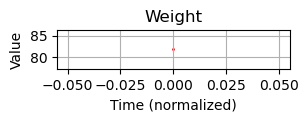

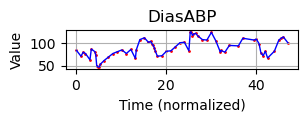

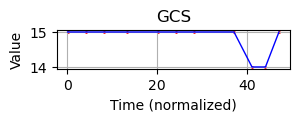

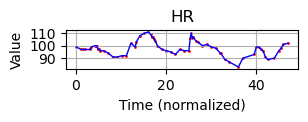

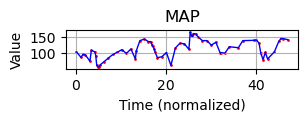

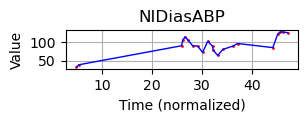

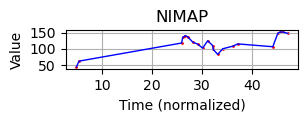

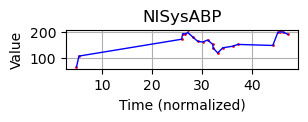

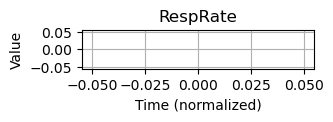

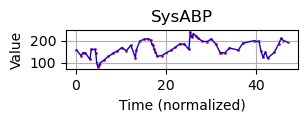

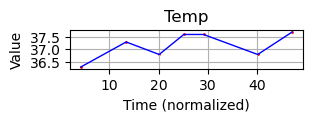

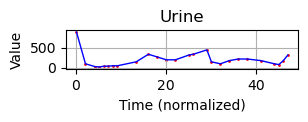

In [87]:
#################################################################
# Play with visualization
################################################################

element = train_data_0[2]
time_steps = element[1]
data = element[2]
mask = element[3]
attribute_filtered_idx_features = np.where(attribute_filtered_idx)[0]
features =  attribute_filtered_idx_features
for i in features:
    feature_name = attr_names[i]
    plt.figure(figsize=(3, 0.5))
    # make a scatter plot
    plt.scatter(time_steps[mask[:, i] == 1], data[mask[:, i] == 1, i], color='red', s=1, label='Observed')
    # make a line plot for the whole time series but not plottting the zeros 
    plot_data = data[:, i][mask[:, i] == 1]
    plt.plot(time_steps[mask[:, i] == 1], plot_data, color='blue', linewidth=1, label='Full time series')
    plt.xlabel('Time (normalized)')
    plt.ylabel('Value')
    plt.title(f'{feature_name}')
    plt.grid()
    plt.show()